In [157]:

import pandas as pd
import numpy as np
import json
import requests
import sys
import urllib

import csv
import re
import ast

import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns

In [158]:
#READ FAILING BUSINESS FILES
food_inspections_orig = pd.read_csv('food_inspections.csv')

fail_biz1 = pd.read_csv('FailBizFile1.csv')
fail_biz2 = pd.read_csv('FailBizFile2.csv')
fail_biz3 = pd.read_csv('FailBizFile3.csv')
fail_biz4 = pd.read_csv('FailBizFile4.csv')
fail_biz5 = pd.read_csv('FailBizFile5.csv')


In [159]:
#MERGE INTO ONE DATAFRAME

businesses_orig = fail_biz1.append(fail_biz2, ignore_index=True)
businesses_orig = businesses_orig.append(fail_biz3, ignore_index=True)
businesses_orig = businesses_orig.append(fail_biz4, ignore_index=True)
businesses_orig = businesses_orig.append(fail_biz5, ignore_index=True)


In [165]:
#CLEAN FAILED BUISNESSES DATA FRAME

    #remove unesseary columns 
businesses = businesses_orig.drop(columns = ['display_phone', 'distance', 'image_url','phone','transactions','url'])

    #remove businesses with less then 5 reviews -i think any less is not enough to accurately rate the place
businesses = businesses[businesses['review_count'] >= 5]

    #ast.literal_eval turns string "{...}" into dict {...} -weird effect of reading from csv to pandas 
businesses['categories'] = businesses['categories'].map(lambda x: ast.literal_eval(x) )
businesses['coordinates'] = businesses['coordinates'].map(lambda x: (ast.literal_eval(x)).values() )

    #takes only the 'title' category names and puts them in a list 
businesses['categories'] = businesses['categories'].map(lambda x: tuple([list(d.values())[1] for d in x]) )

    #converts price $ to ints. NaN = 0 
businesses['price'] = businesses['price'].map(lambda x: sum([y == "$" for y in str(x)]))

    #gets address and turns it into list 
businesses['location'] = businesses['location'].map(lambda x: (ast.literal_eval(x))['display_address'] )

# businesses

In [166]:
    #CHECK if both yelp data and inspection data correspond to the same place and FILTER out bad matchs

    #regx to get a word no punctuation
re_word = re.compile(r'([a-z]+)')
    #get the first word from the food inspection names 
first_word = businesses['FI Name'].map(lambda x: (re.search(re_word, x ).group())  )

    #check if first word is contained in yelp name to determine if restaurant correctly matchs the food inspections restaurant
    #filter businesses to only contain best match
businesses['correct match'] = first_word.combine(businesses['alias'], lambda x1, x2: True if x1 in x2 else False)
businesses = businesses[businesses['correct match'] == True]
businesses = businesses.drop( columns = ['correct match', 'alias'])


In [168]:
#CLEAN FAILED FOOD INSPECTION DATA SOME MORE

    #read failed inspection data and drop uneeded columns
failed_food_inspections = pd.read_csv('failed_food_inspections.csv').drop(columns = ['Results','Zip','AKA Name', 'Facility Type','Latitude', 'Longitude','Location','State', 'City'])

    #finds violation numbers and puts them in a list 
failed_food_inspections['Violations'] = failed_food_inspections['Violations'].str.findall(r'\w([1-9][0-9]?)\.')

    #turn risk value into a digit: 0 = N/A | 1 = low | 2 = medium | 3 = high
failed_food_inspections['Risk'] = failed_food_inspections['Risk'].str.findall(r'\d')

def makeint(lst):
    try:
        return int(lst[0])
    except:
        return 0
failed_food_inspections['Risk'] = failed_food_inspections['Risk'].map(lambda x: makeint(x) )

    #drops rows that have no violation codes
failed_food_inspections_violations = failed_food_inspections[failed_food_inspections['Violations'].notnull()]


In [169]:
# JOIN FOOD INSPECTION AND YELP BUSINESS DATAFRAMES

merged = failed_food_inspections.merge(businesses, left_on = 'DBA Name', right_on = 'FI Name')
merged = merged_orig.drop_duplicates('Inspection ID')

In [170]:
#___________________________DATA ANYLSIS___________________________

In [171]:
    #most wide spread restaurant chains in failed inspections 
merged_no_dup_lic = merged.drop_duplicates('License #')
most_fails = merged_no_dup_lic['DBA Name'].value_counts()
most_fails = most_fails.head(20)

    #raw data of all inspections 
food_inspections = food_inspections_orig.drop_duplicates('License #')
    #most wide spread restaurant chains in normal inspections 
num = food_inspections['DBA Name'].value_counts()

subway_fails = most_fails['subway']/num['SUBWAY']
DD_fails = most_fails['dunkin donuts']/num['DUNKIN DONUTS']
mcd_fails = most_fails["mcdonald's"]/num["MCDONALD'S"]

print(str(round(DD_fails, 2)) + '% of Dunkin Donuts failing inspections') 
print(str(round(mcd_fails,2)) + '% of McDonalds failing inspections') 
print(str(round(subway_fails,2)) + '% of Subways failing inspections') 

0.58% of Dunkin Donuts failing inspections
0.85% of McDonalds failing inspections
0.56% of Subways failing inspections


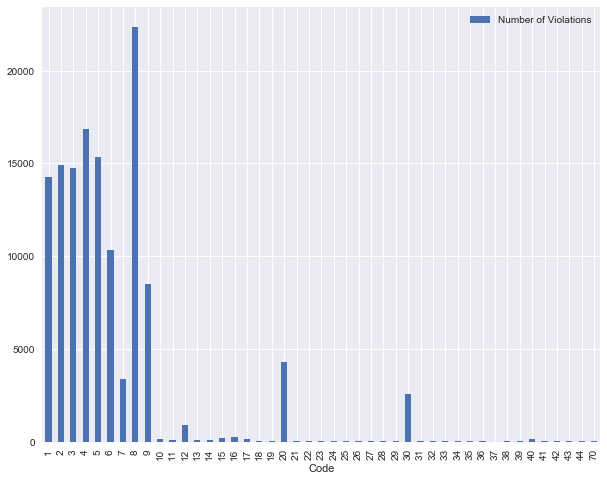

In [130]:
#FIND MOST COMMON CODE VIOLATIONS

    # Violation Codes
    # 1-14 : critical
    # 15-29 :serious
    # 30-44, 70 : minor
    
    #valid code numbers joined into list 
codes = list(range(1,45))+[70] 
lst = []
for v in failed_food_inspections_violations['Violations']:
    lst += v

    #num of each violation
inspection_codes = pd.Series(lst).value_counts()

inspection_codes = inspection_codes.to_frame().reset_index()
inspection_codes.columns = ['Code', 'Number of Violations']
inspection_codes['Code'] = inspection_codes['Code'].map(lambda x: int(x))

    #filters to only include relevent codes
inspection_codes = inspection_codes[inspection_codes['Code'].isin(codes)] 
inspection_codes.set_index('Code', inplace = True)
inspection_codes.sort_index(ascending = True, inplace = True)

    #Plot Frequency of differnet codes
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,8)
inspection_codes.plot.bar()


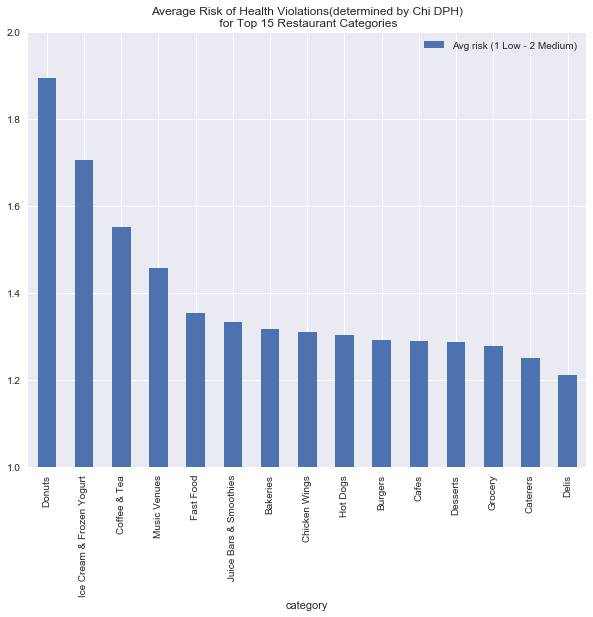

In [173]:
#AVERAGE RISK OF FAILURE FOR EACH RESTAURANT CATEGORY 

    #remove duplicate restaurants
merged_no_dup = merged.drop_duplicates('id')
merged_no_dup = merged_no_dup[merged_no_dup['Risk'] > 0]

    #iterate through rows and then thru Category tuples. Have every category with its risk in 2 lists 
cats = []
risk = []
for index, row in merged_no_dup.iterrows():
    rsk = row['Risk']
    for val in row['categories']:
        cats.append(val)
        risk.append(int(rsk))

    #create series with categories and coressponding risk. counts of categories
num_cats = pd.Series(cats).value_counts()
    #filter out any catagories that appear less then 15 times bc they are less relevent
num_cats = num_cats[num_cats > 15]
rel_cats = num_cats.index


df = pd.Series(risk, index = cats).to_frame().reset_index()
df.columns=['category', 'risk'] 

    #for RAW Graphs Circle Packing data vis 
df_filtered = df[df['category'].isin(rel_cats)]
df_filtered.to_csv("./cat_risk_for_RAW_Vis.csv", sep =',', index=False)

    #for Avg risk per category 
avg_risk = df_filtered.groupby('category').mean()

avg_risk = avg_risk.sort_values('risk', ascending = False)
avg_risk_top15 = avg_risk.head(15)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10,8)
avg_risk_top15.plot.bar(ylim = (1,2)).legend(["Avg risk (1 Low - 2 Medium)"])
plt.title('Average Risk of Health Violations(determined by Chi DPH)\n for Top 15 Restaurant Categories')

2    1662
1    1290
3     188
4      33
Name: price, dtype: int64


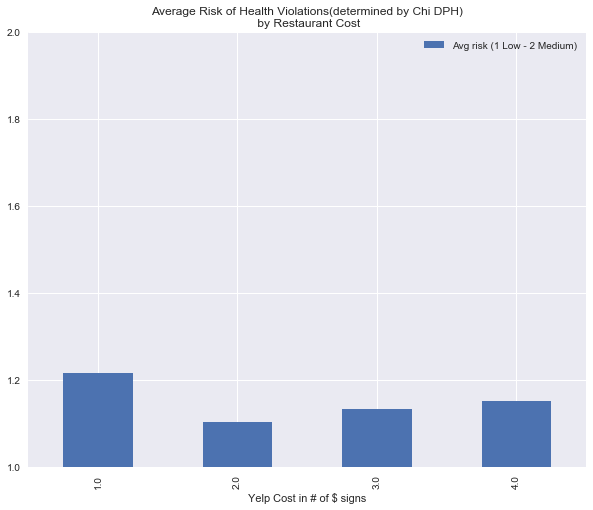

In [174]:
#COST VS RISK LEVEL

    #remove costs of 0
price = merged_no_dup['price'][merged_no_dup['price'] > 0] 
print(price.value_counts(0))
    #create dataframe with cost and risk. drop NaN values
cost_risk = pd.concat([price, merged_no_dup['Risk']],axis = 1).reset_index(drop = True).dropna(axis = 0,how = 'any')
    #get avg risk for each price
    

cost_risk = cost_risk.groupby('price').mean()
cost_risk.index.names = ["Yelp Cost in # of $ signs"]

%matplotlib inline
plt.rcParams['figure.figsize'] = (10,8)
cost_risk.plot.bar(ylim = (1,2)).legend(["Avg risk (1 Low - 2 Medium)"])
plt.title('Average Risk of Health Violations(determined by Chi DPH)\n by Restaurant Cost')



4.0    1123
3.5     951
4.5     476
3.0     419
2.5     190
2.0      79
5.0      61
1.5      37
1.0       4
Name: rating, dtype: int64


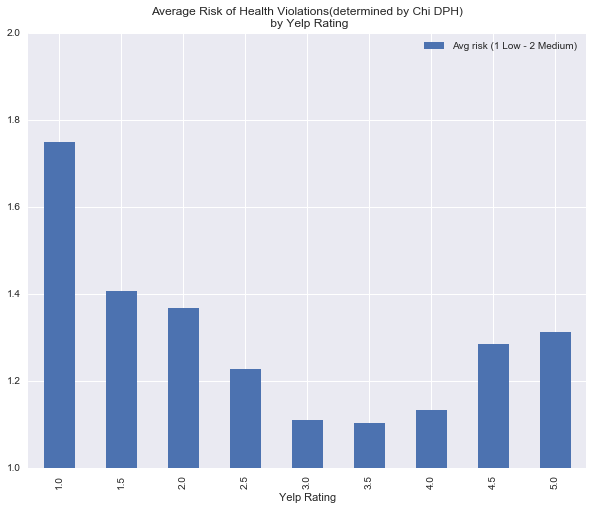

In [175]:
#RATING VS RISK LEVEL
rating_risk = pd.concat([merged_no_dup['rating'], merged_no_dup['Risk']],axis = 1).reset_index(drop = True).dropna(axis = 0,how = 'any')
print(merged_no_dup['rating'].value_counts())
rating_risk = rating_risk.groupby('rating').mean()
rating_risk.index.names = ["Yelp Rating"] 

%matplotlib inline
plt.rcParams['figure.figsize'] = (10,8)
rating_risk.plot.bar(ylim = (1,2)).legend(["Avg risk (1 Low - 2 Medium)"])
plt.title('Average Risk of Health Violations(determined by Chi DPH)\n by Yelp Rating')
